# Lending Club Default Models

In [1]:
#Libraries
import pandas as pd
import os
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from collections import Counter
from sklearn.model_selection import train_test_split

#Display settings 
display = pd.options.display
display.max_columns = 1000
display.max_rows = 1000
display.max_colwidth = 199
display.width = 1000

In [2]:
#files
dir_name = os.getcwd()
file_name = '/Loan_status_2007-2020Q3.gzip'
dir_path = dir_name+file_name

meta_name = '/LCDataDictionary.xlsx'
meta_path = dir_name+meta_name

In [3]:
metaData = pd.read_excel(meta_path, engine='openpyxl') #utf-8 reading issues; openpyxl works best

metaData.style.set_properties(subset=['Description'], **{'width': '1000px'})

In [4]:
#Read Data

loanData = pd.read_csv(dir_path, low_memory=False, index_col=0)
loanData.head()
loanData.shape

#Missing Data - we might drop these
missing_percent = loanData.isnull().mean().sort_values(ascending=False)
missing_percent.head(50)

/Users/arun/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


hardship_loan_status                          0.950979
hardship_reason                               0.950903
hardship_status                               0.950902
hardship_dpd                                  0.950902
hardship_type                                 0.950901
hardship_length                               0.950901
payment_plan_start_date                       0.950901
hardship_end_date                             0.950901
hardship_start_date                           0.950901
deferral_term                                 0.950901
orig_projected_additional_accrued_interest    0.938732
hardship_payoff_balance_amount                0.937762
hardship_amount                               0.937762
hardship_last_payment_amount                  0.937762
sec_app_revol_util                            0.933486
verification_status_joint                     0.933417
revol_bal_joint                               0.932380
sec_app_chargeoff_within_12_mths              0.932379
sec_app_nu

In [5]:
# Encoding the `loan_status`
# status 1: 'Charged Off', 'Late (16-30 days)', 'Late (31-120 days)', 'Default'
# status 0: 'Fully Paid'
keep_status = ['Charged Off', 'Fully Paid', 'Late (16-30 days)', 'Late (31-120 days)', 'Default', 'Current']
loanData = loanData[loanData['loan_status'].isin(keep_status)]

#create a chargeoff flag
loanData['coFlag'] = 1
loanData.loc[loanData['loan_status'].isin(['Fully Paid','Late (16-30 days)','Current']), 'coFlag'] = 0

In [6]:
loanData['loan_status'].value_counts()

Fully Paid            1497783
Current               1031016
Charged Off            362548
Late (31-120 days)      16154
Late (16-30 days)        2719
Default                   433
Name: loan_status, dtype: int64

In [7]:
print(loanData.dtypes)

id                                             object
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                       object
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                                            object
purpose                     

In [8]:
loanData.head()

id  loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  installment grade sub_grade                 emp_title emp_length home_ownership  annual_inc verification_status   issue_d  loan_status pymnt_plan                                                               url         purpose                 title zip_code addr_state    dti  delinq_2yrs earliest_cr_line  fico_range_low  fico_range_high  inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  pub_rec  revol_bal revol_util  total_acc initial_list_status  out_prncp  out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  recoveries  collection_recovery_fee last_pymnt_d  last_pymnt_amnt next_pymnt_d last_credit_pull_d  last_fico_range_high  last_fico_range_low  collections_12_mths_ex_med  mths_since_last_major_derog  policy_code application_type  annual_inc_joint  dti_joint verification_status_joint  acc_now_delinq  tot_coll_amt  tot_cur_bal  \
0  1077501     5000.0       5000.0           4975.0   36 months   10.65%       162.87     B        B2                       NaN  10+ years           RENT     24000.0            Verified  Dec-2011   Fully Paid          n  https://lendingclub.com/browse/loanDetail.action?loan_id=1077501     credit_card              Computer    860xx         AZ  27.65          0.0         Jan-1985           735.0            739.0             1.0                     NaN                     NaN       3.0      0.0    13648.0      83.7%        9.0                   f        0.0            0.0   5863.155187          5833.84          5000.00         863.16                0.00         0.0                     0.00     Jan-2015           171.62          NaN           May-2020                 704.0                700.0                         0.0                          NaN          1.0       Individual               NaN        NaN                       NaN             0.0           NaN          NaN   
1  1077430     2500.0       2500.0           2500.0   60 months   15.27%        59.83     C        C4                     Ryder   < 1 year           RENT     30000.0     Source Verified  Dec-2011  Charged Off          n  https://lendingclub.com/browse/loanDetail.action?loan_id=1077430             car                  bike    309xx         GA   1.00          0.0         Apr-1999           740.0            744.0             5.0                     NaN                     NaN       3.0      0.0     1687.0       9.4%        4.0                   f        0.0            0.0   1014.530000          1014.53           456.46         435.17                0.00       122.9                     1.11     Apr-2013           119.66          NaN           Oct-2016                 499.0                  0.0                         0.0                          NaN          1.0       Individual               NaN        NaN                       NaN             0.0           NaN          NaN   
2  1077175     2400.0       2400.0           2400.0   36 months   15.96%        84.33     C        C5                       NaN  10+ years           RENT     12252.0        Not Verified  Dec-2011   Fully Paid          n  https://lendingclub.com/browse/loanDetail.action?loan_id=1077175  small_business  real estate business    606xx         IL   8.72          0.0         Nov-2001           735.0            739.0             2.0                     NaN                     NaN       2.0      0.0     2956.0      98.5%       10.0                   f        0.0            0.0   3005.666844          3005.67          2400.00         605.67                0.00         0.0                     0.00     Jun-2014           649.91          NaN           Jun-2017                 739.0                735.0                         0.0                          NaN          1.0       Individual               NaN        NaN                       NaN             0.0           NaN          NaN   
3  1076863    10000.0      10000.0          10000.0 

In [9]:
#Data cleanup
loanData['int_rate'] = loanData['int_rate'].str[:-1].astype(float) #Strip off the %sign
loanData['revol_util'] = loanData['revol_util'].str[:-1].astype(float) #Strip off the %sign

loanData['emp_length'].fillna(value=-1,inplace=True)
loanData['emp_length'].replace(to_replace='< 1 year', value='0', inplace=True)
loanData['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True,regex=True)

In [10]:
#New features

#Length of credit file - thin file elimination
loanData['issue_date']  = loanData["issue_d"].apply(lambda x: datetime.strptime(x, "%b-%Y"))
loanData['oldest_credit_date']  = loanData["earliest_cr_line"].apply(lambda x: datetime.strptime(x, "%b-%Y"))
loanData['credit_hist'] = loanData.issue_date.dt.to_period('M') - loanData.oldest_credit_date.dt.to_period('M')
loanData['credit_hist'] = loanData['credit_hist'].map(lambda x: x.n) 
#loanData[['oldest_credit_date','issue_date','credit_hist']].head()

#FICO
loanData['fico'] = (loanData['fico_range_low']+loanData['fico_range_high'])/2
loanData['refreshFico'] = (loanData['last_fico_range_low']+loanData['last_fico_range_high'])/2

#Funded Ratio
loanData['fund_ratio'] = loanData['funded_amnt'].div(loanData['loan_amnt'])


#Funded Ratio
loanData['loan_to_inc'] = loanData['funded_amnt'].div(loanData['annual_inc'])


In [11]:
#Remove temporal variables - since we want to predict propensity to default @Origination
#https://www.kaggle.com/tysonpo/columns-available-at-origination-answer

temporal_vars_remove = ['last_credit_pull_d','last_fico_range_high','last_fico_range_low','total_pymnt',
                        'total_pymnt_inv','recoveries','collection_recovery_fee','out_prncp','out_prncp_inv',
                        'total_rec_prncp','total_rec_int','last_pymnt_d','last_pymnt_amnt','next_pymnt_d',
                        'total_rec_late_fee','hardship_flag','hardship_amount',
                        'orig_projected_additional_accrued_interest','hardship_payoff_balance_amount',
                        'hardship_last_payment_amount','debt_settlement_flag','hardship_type','hardship_reason',
                        'hardship_status','deferral_term','hardship_start_date','hardship_end_date','payment_plan_start_date',
                        'hardship_length','hardship_dpd','hardship_loan_status','installment','pymnt_plan',
                        'acc_now_delinq']

other_vars_remove  = ['url','oldest_credit_date','earliest_cr_line','last_fico_range_low','last_fico_range_high','policy_code','zip_code',
                      'sec_app_fico_range_low','sec_app_fico_range_high','sec_app_earliest_cr_line','fico_range_low', 'fico_range_high',
                     'annual_inc_joint','dti_joint','verification_status_joint', 'revol_bal_joint','sec_app_inq_last_6mths',
                     'sec_app_mort_acc','sec_app_open_acc','sec_app_revol_util','sec_app_open_act_il',
                      'sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med'
                     ]

print(len(loanData.columns), len(temporal_vars_remove), len(other_vars_remove))

vars_to_remove = temporal_vars_remove + other_vars_remove

loanData.drop(vars_to_remove, axis=1, inplace=True)
#loanDataBkp = loanData.copy()

149 34 24


In [12]:
#loanDataBkp = loanData.copy()

In [12]:
# define categorical and numerical features
cat_features = ['term', 'home_ownership', 'verification_status', 'purpose', 
                'title', 'addr_state', 'initial_list_status', 'application_type', 
                'grade', 'sub_grade']

num_features = ['loan_amnt', 'int_rate','loan_to_inc', 'emp_length', 
                'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 
                'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 
                'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 
                'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 
                'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 
                'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
                'inq_last_6mths','mths_since_last_delinq','mths_since_last_record',
                'open_acc_6m','open_act_il','open_il_12m','open_il_24m','mths_since_rcnt_il',
                'total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util','inq_fi',
                'total_cu_tl','inq_last_12m','mths_since_recent_bc_dlq','mths_since_recent_revol_delinq',
                'mths_since_last_major_derog','num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
                'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
                'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
                'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
                'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit','mths_since_last_major_derog',
                'total_il_high_credit_limit', 'credit_hist','fund_ratio','fico','refreshFico']

yVar = ['coFlag']

In [13]:
#More Data cleanup

loanData[num_features] = loanData[num_features].astype(float)

loanData.replace([np.inf, -np.inf], np.nan,inplace=True)

loanData.replace(np.nan,0,inplace=True)

In [14]:
#loanData.groupby(['issue_date','coFlag'])['coFlag'].count()

In [15]:
loanData.head()

id  loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate grade sub_grade                 emp_title  emp_length home_ownership  annual_inc verification_status   issue_d  loan_status         purpose                 title addr_state    dti  delinq_2yrs  inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  pub_rec  revol_bal  revol_util  total_acc initial_list_status  collections_12_mths_ex_med  mths_since_last_major_derog application_type  tot_coll_amt  tot_cur_bal  open_acc_6m  open_act_il  open_il_12m  open_il_24m  mths_since_rcnt_il  total_bal_il  il_util  open_rv_12m  open_rv_24m  max_bal_bc  all_util  total_rev_hi_lim  inq_fi  total_cu_tl  inq_last_12m  acc_open_past_24mths  avg_cur_bal  bc_open_to_buy  bc_util  chargeoff_within_12_mths  delinq_amnt  mo_sin_old_il_acct  mo_sin_old_rev_tl_op  mo_sin_rcnt_rev_tl_op  mo_sin_rcnt_tl  mort_acc  mths_since_recent_bc  mths_since_recent_bc_dlq  mths_since_recent_inq  mths_since_recent_revol_delinq  \
0  1077501     5000.0       5000.0           4975.0   36 months     10.65     B        B2                         0        10.0           RENT     24000.0            Verified  Dec-2011   Fully Paid     credit_card              Computer         AZ  27.65          0.0             1.0                     0.0                     0.0       3.0      0.0    13648.0        83.7        9.0                   f                         0.0                          0.0       Individual           0.0          0.0          0.0          0.0          0.0          0.0                 0.0           0.0      0.0          0.0          0.0         0.0       0.0               0.0     0.0          0.0           0.0                   0.0          0.0             0.0      0.0                       0.0          0.0                 0.0                   0.0                    0.0             0.0       0.0                   0.0                       0.0                    0.0                             0.0   
1  1077430     2500.0       2500.0           2500.0   60 months     15.27     C        C4                     Ryder         0.0           RENT     30000.0     Source Verified  Dec-2011  Charged Off             car                  bike         GA   1.00          0.0             5.0                     0.0                     0.0       3.0      0.0     1687.0         9.4        4.0                   f                         0.0                          0.0       Individual           0.0          0.0          0.0          0.0          0.0          0.0                 0.0           0.0      0.0          0.0          0.0         0.0       0.0               0.0     0.0          0.0           0.0                   0.0          0.0             0.0      0.0                       0.0          0.0                 0.0                   0.0                    0.0             0.0       0.0                   0.0                       0.0                    0.0                             0.0   
2  1077175     2400.0       2400.0           2400.0   36 months     15.96     C        C5                         0        10.0           RENT     12252.0        Not Verified  Dec-2011   Fully Paid  small_business  real estate business         IL   8.72          0.0             2.0                     0.0                     0.0       2.0      0.0     2956.0        98.5       10.0                   f                         0.0                          0.0       Individual           0.0          0.0          0.0          0.0          0.0          0.0                 0.0           0.0      0.0          0.0          0.0         0.0       0.0               0.0     0.0          0.0           0.0                   0.0          0.0             0.0      0.0                       0.0          0.0                 0.0                   0.0                    0.0             0.0       0.0                   0.0                       0.0                    0.0                             0.0   
3  1076863    10000.

In [16]:
# split into train test and holdout sets
loanData_test_train = loanData[loanData.issue_date <= '2019-09-01']
holdOut = loanData[loanData.issue_date > '2019-09-01'] #Out of time holdout

devSet, holdOutAdd  = train_test_split(loanData_test_train, test_size=0.03, random_state=693)#In sample holdout

holdOut = holdOut.append(holdOutAdd) #In + Out sample holdout

trainSet, testSet = train_test_split(devSet,test_size=0.3, random_state=693) #test and train splits

devSet.reset_index(inplace=True)
trainSet.reset_index(inplace=True)
testSet.reset_index(inplace=True)
holdOut.reset_index(inplace=True)

devSet.drop('index', axis=1, inplace=True)

print(len(loanData.index),len(trainSet.index), len(testSet.index), len(holdOut.index))

print(holdOut['coFlag'].value_counts())

#dupRows = loanData[loanData.duplicated()]
#print(len(dupRows))

2910653 1792074 768033 350546
0    336891
1     13655
Name: coFlag, dtype: int64


/Users/arun/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [17]:
#loanData['issue_d'].value_counts()

In [18]:
loanData.columns.values

array(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'title', 'addr_state', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'application_type', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m',
       'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
       'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m',
       'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'm

In [19]:
loanData[loanData.funded_amnt!=loanData.loan_amnt].tail()

id  loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate grade sub_grade     emp_title  emp_length home_ownership  annual_inc verification_status   issue_d loan_status             purpose               title addr_state    dti  delinq_2yrs  inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  pub_rec  revol_bal  revol_util  total_acc initial_list_status  collections_12_mths_ex_med  mths_since_last_major_derog application_type  tot_coll_amt  tot_cur_bal  open_acc_6m  open_act_il  open_il_12m  open_il_24m  mths_since_rcnt_il  total_bal_il  il_util  open_rv_12m  open_rv_24m  max_bal_bc  all_util  total_rev_hi_lim  inq_fi  total_cu_tl  inq_last_12m  acc_open_past_24mths  avg_cur_bal  bc_open_to_buy  bc_util  chargeoff_within_12_mths  delinq_amnt  mo_sin_old_il_acct  mo_sin_old_rev_tl_op  mo_sin_rcnt_rev_tl_op  mo_sin_rcnt_tl  mort_acc  mths_since_recent_bc  mths_since_recent_bc_dlq  mths_since_recent_inq  mths_since_recent_revol_delinq  \
188174   1062334    20000.0      12675.0          12675.0   60 months     14.27     C        C2  RR DONNELLEY        10.0       MORTGAGE     60000.0     Source Verified  Jan-2012  Fully Paid  debt_consolidation              payoff         WI  16.64          0.0             0.0                     0.0                     0.0      12.0      0.0    18539.0        84.3       26.0                   f                         0.0                          0.0       Individual           0.0          0.0          0.0          0.0          0.0          0.0                 0.0           0.0      0.0          0.0          0.0         0.0       0.0               0.0     0.0          0.0           0.0                   0.0          0.0             0.0      0.0                       0.0          0.0                 0.0                   0.0                    0.0             0.0       0.0                   0.0                       0.0                    0.0                             0.0   
188180   1058291    12000.0       7775.0           7775.0   60 months     15.27     C        C4             0         7.0           RENT     50000.0            Verified  Jan-2012  Fully Paid         credit_card           refinance         VA   5.50          0.0             1.0                     0.0                     0.0      13.0      0.0     7008.0        37.9       25.0                   f                         0.0                          0.0       Individual           0.0          0.0          0.0          0.0          0.0          0.0                 0.0           0.0      0.0          0.0          0.0         0.0       0.0               0.0     0.0          0.0           0.0                   0.0          0.0             0.0      0.0                       0.0          0.0                 0.0                   0.0                    0.0             0.0       0.0                   0.0                       0.0                    0.0                             0.0   
32403   80749289    18000.0      10000.0          10000.0   36 months     12.99     C        C2       Manager         6.0           RENT     60000.0     Source Verified  Jun-2016  Fully Paid      small_business            Business         WA  20.45          0.0             1.0                     0.0                     0.0       9.0      0.0    15537.0        43.4       12.0                   w                         0.0                          0.0       Individual         155.0      28657.0          1.0          1.0          0.0          0.0                28.0       12376.0     62.0          1.0          1.0      4705.0      51.0           35800.0     0.0          1.0           2.0                   1.0       3184.0         19046.0     39.7                       0.0          0.0                74.0                  90.0                    4.0             4.0       0.0                  43.0                       0.0                    4.0                             0.0   
32441   79101538    20000.0      10000.0      

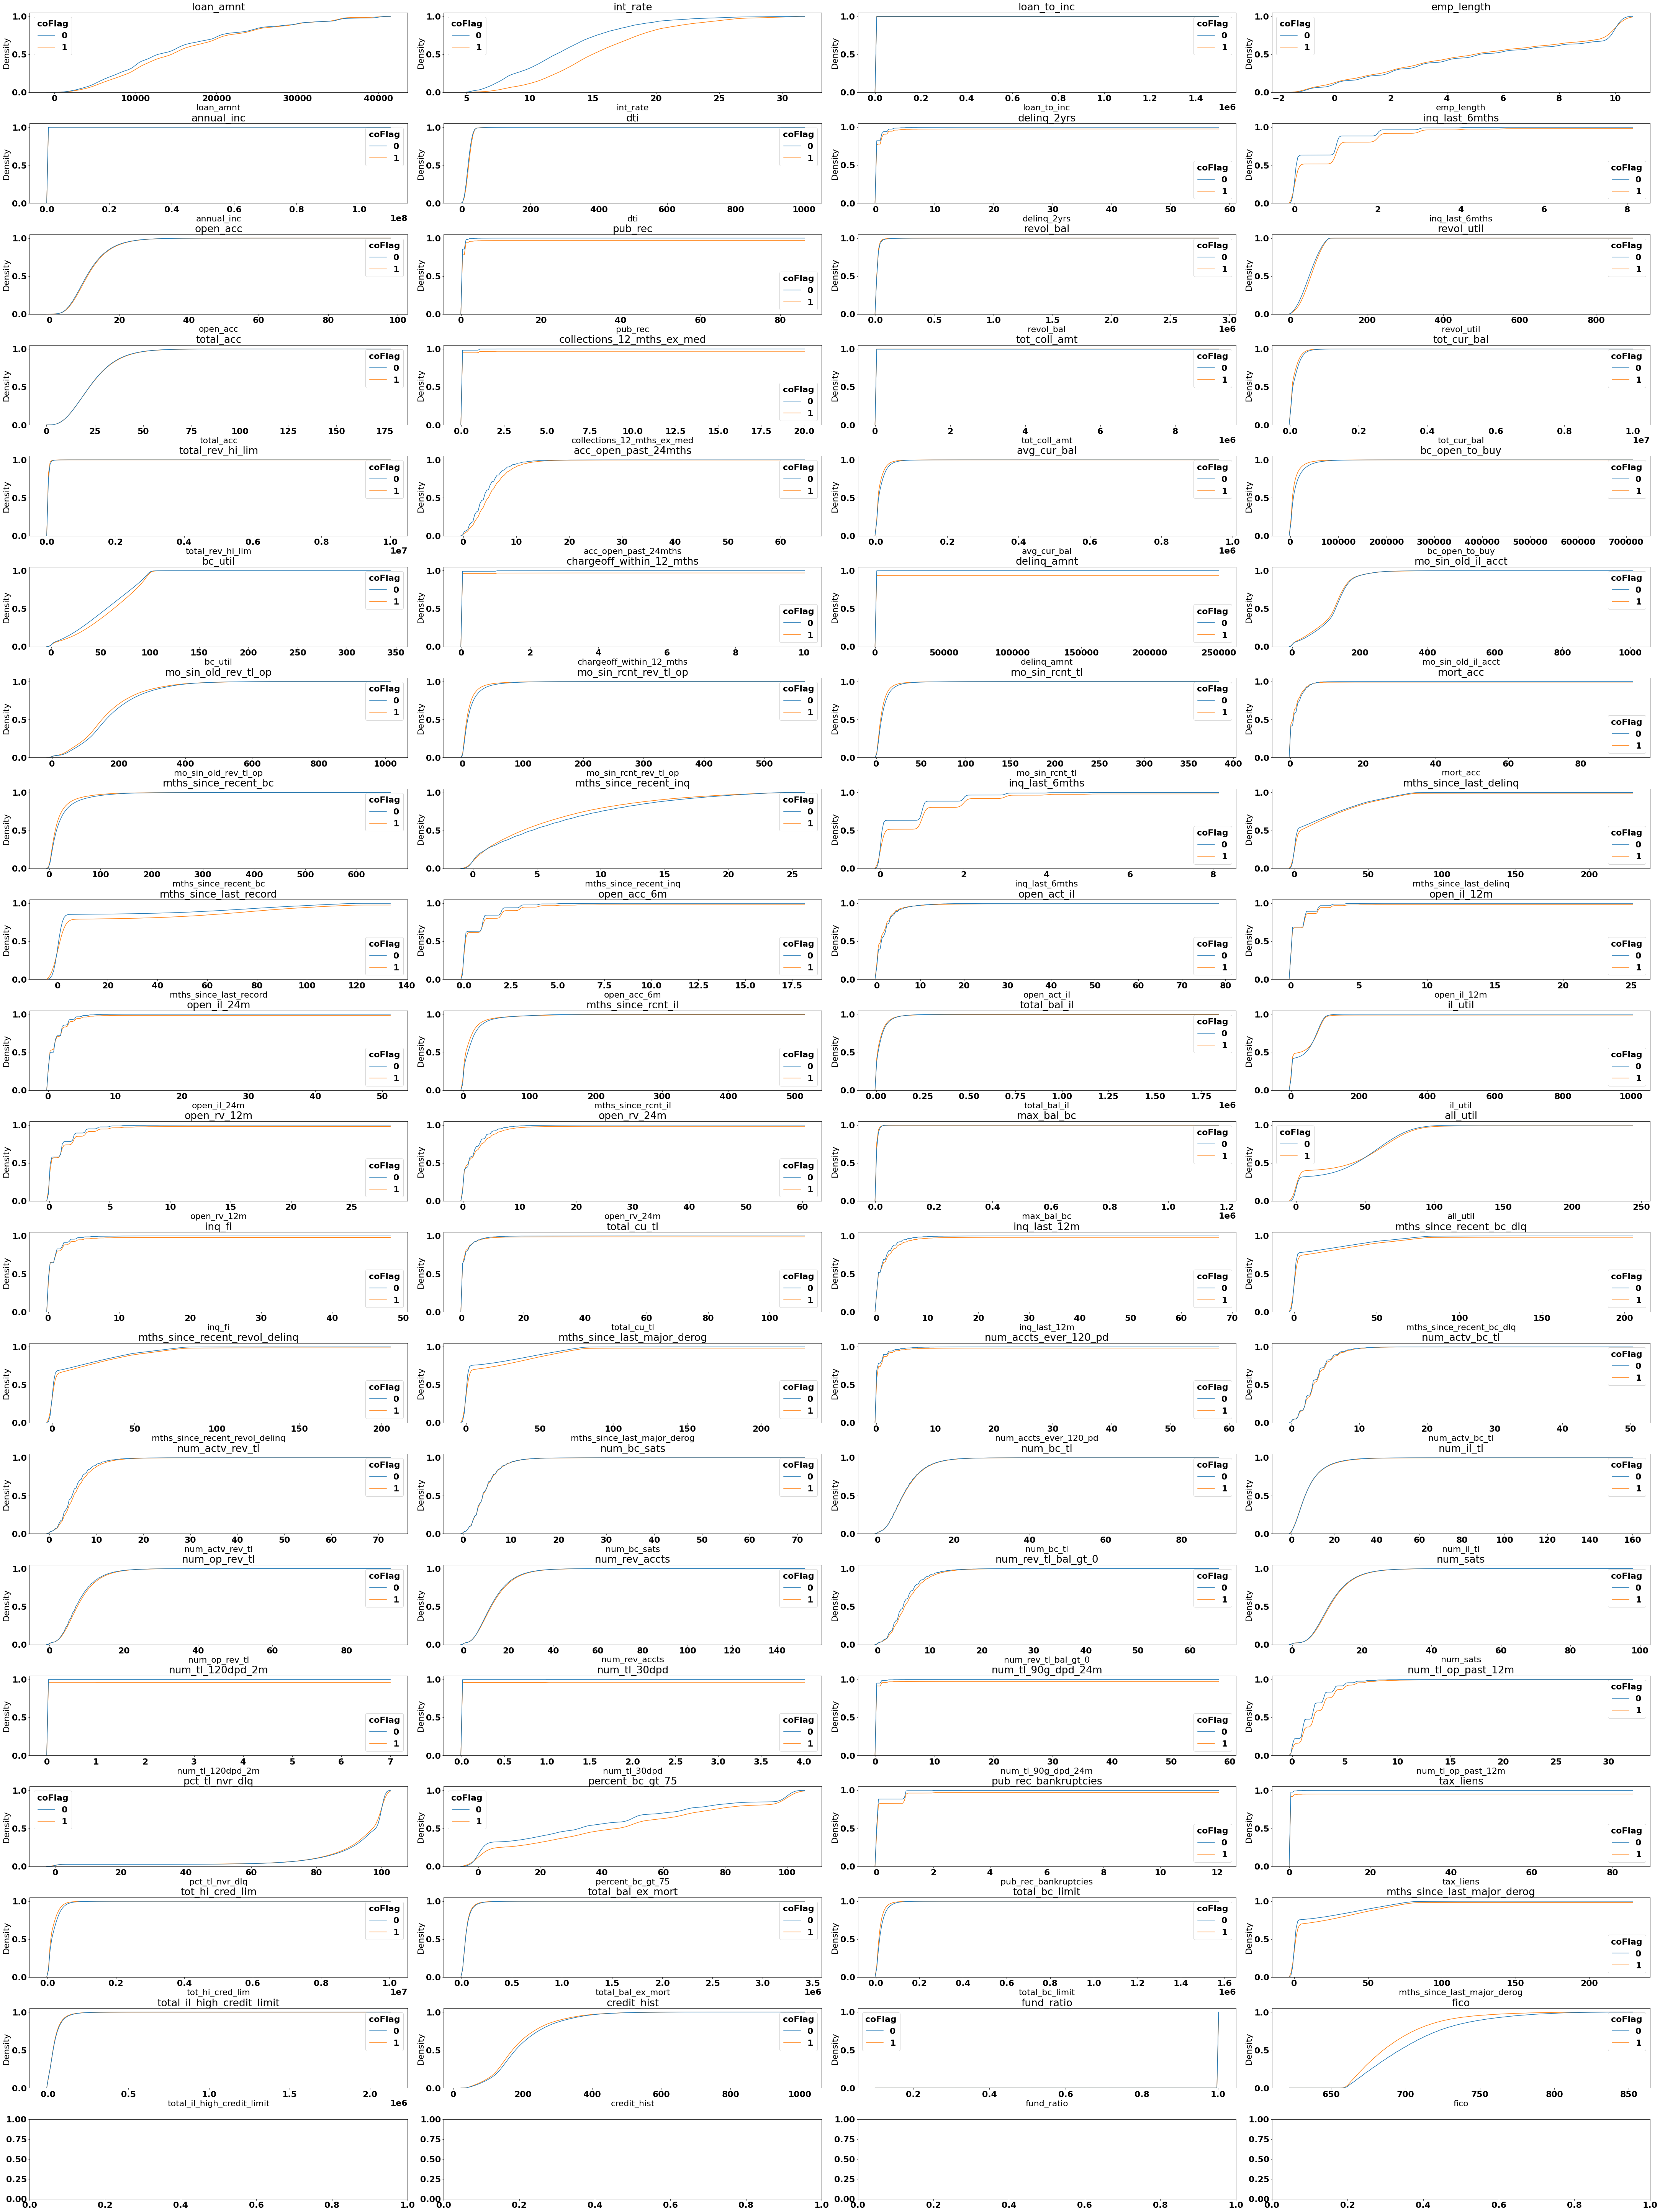

In [49]:
keep_vars = num_features


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

#keep_vars = ['loan_amnt','int_rate','emp_length', 'mort_acc', 'mths_since_recent_bc', 
#             'mths_since_recent_inq','total_il_high_credit_limit', 'credit_hist']

colNum =0
ncols = 4
nrows = 20
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(40, 120))
for row in range(0,nrows):
    for col in range(0,ncols):
            if(colNum < len(keep_vars)-1):
                sns.kdeplot(data=devSet, x = devSet[keep_vars[colNum]], hue="coFlag",cumulative=True,common_norm=False, common_grid=True,ax=axes[row, col])
                axes[row, col].set_title(keep_vars[colNum])
                colNum = colNum+1
                
fig.tight_layout(pad=0, h_pad=.15, w_pad=.15)

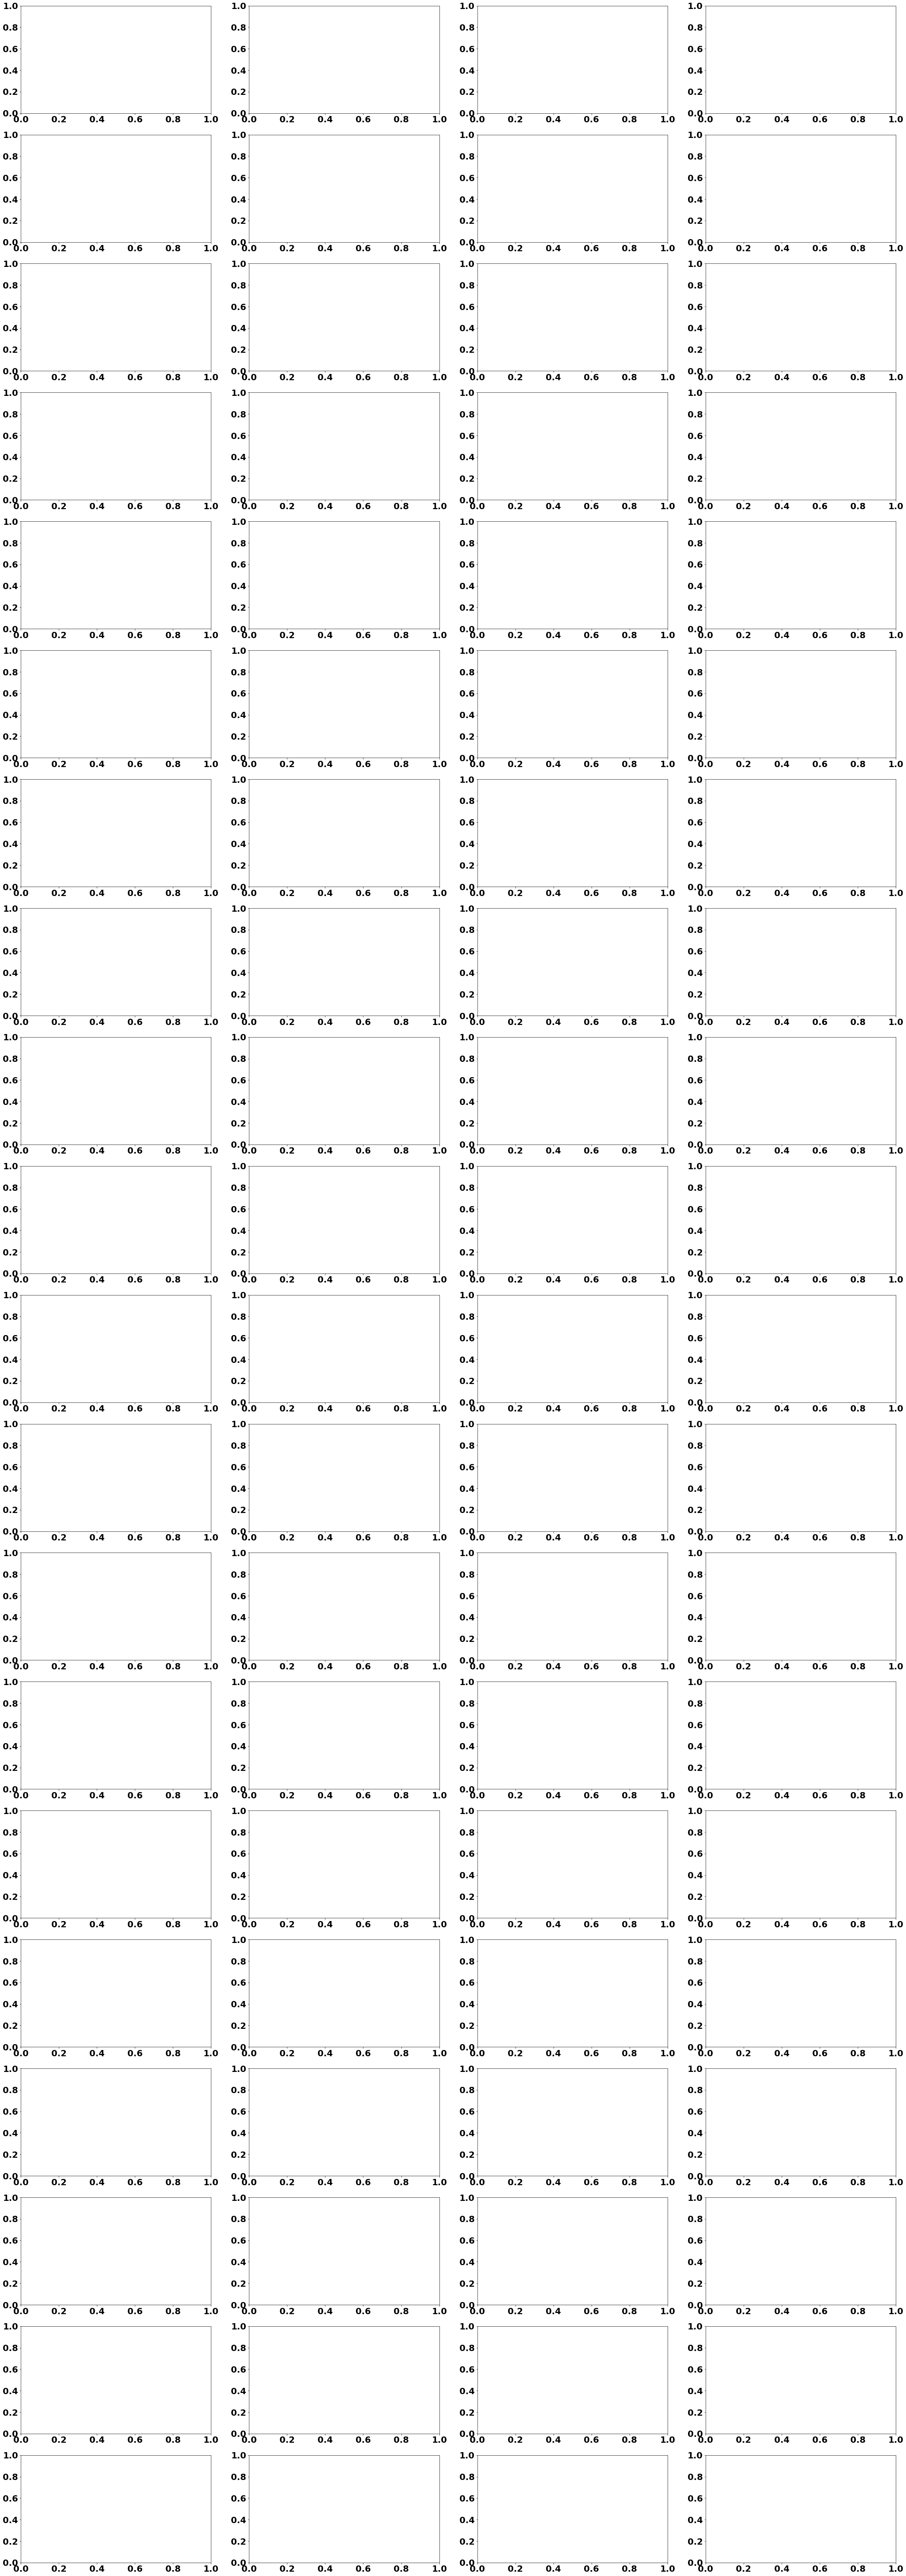

In [54]:
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(40, 120))

In [20]:
len(num_features)

77

In [21]:
#sns.pairplot(loanData[['fund_ratio','coFlag']], hue="coFlag", height=2.5)
#sns.kdeplot(data=loanData, x="credit_hist", hue="coFlag",cumulative=True, common_norm=False,common_grid=True)

In [22]:
loanData.groupby(['coFlag'])['max_bal_bc'].mean()

coFlag
0    4401.605006
1    3114.171021
Name: max_bal_bc, dtype: float64

In [ ]:
colNum = 0
fig, axes = plt.subplots(figsize=(6, 6), ncols=4, nrows=7)
for row in range(0, 7):
    for col in range(0, 4):
        if (colNum < len(keep_vars)-1):
            axes[row, col].scatter(loanData['coFlag'], loanData[keep_vars[colNum]])
            axes[row, col].set_xlabel(keep_vars[colNum])
            axes[row, col].set_title(keep_vars[colNum])
            colNum = colNum + 1


In [ ]:
# Kruskal Wallis test - didn't run
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mstats
# seed the random number generator
seed(1)

# compare samples
for var in num_features:
    H, pval = mstats.kruskalwallis((devSetv[devSetv['coFlag']==1][var].values), (devSetv[devSetv['coFlag']==0][var].values))
    alpha = 0.01

    #print("H-statistic:\t%s\nP-value:\t%s" % (str(H),str(pval)))
    if str(pval) < alpha:
        print(var)

In [ ]:
mstats.kruskalwallis((trainSet[trainSet['coFlag']==1]['max_bal_bc'].values), (trainSet[trainSet['coFlag']==0]['max_bal_bc'].values))

In [ ]:
#Correlation Matrix
corrMatrix = devSet.corr()
y = loanData['coFlag']
correl_vars = ['loan_amnt','loan_to_inc','int_rate','emp_length', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq','total_il_high_credit_limit', 'credit_length']

sns.set(style="white")
df = devSet[correl_vars]
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(df, palette=["red"])
g.map_upper(plt.scatter, hue="coFlag", , palette="Set2", s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

In [24]:
#Correlation Matrix
corrMatrix = devSet.corr()
matrix = np.triu(corrMatrix)
corrMatrix

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  emp_length  annual_inc       dti  delinq_2yrs  inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc   pub_rec  revol_bal  revol_util  total_acc  collections_12_mths_ex_med  mths_since_last_major_derog  tot_coll_amt  tot_cur_bal  open_acc_6m  open_act_il  open_il_12m  open_il_24m  mths_since_rcnt_il  total_bal_il   il_util  open_rv_12m  open_rv_24m  max_bal_bc  all_util  total_rev_hi_lim    inq_fi  total_cu_tl  inq_last_12m  acc_open_past_24mths  avg_cur_bal  bc_open_to_buy   bc_util  chargeoff_within_12_mths  delinq_amnt  mo_sin_old_il_acct  mo_sin_old_rev_tl_op  mo_sin_rcnt_rev_tl_op  mo_sin_rcnt_tl  mort_acc  mths_since_recent_bc  mths_since_recent_bc_dlq  mths_since_recent_inq  mths_since_recent_revol_delinq  num_accts_ever_120_pd  num_actv_bc_tl  num_actv_rev_tl  num_bc_sats  num_bc_tl  num_il_tl  num_op_rev_tl  num_rev_accts  num_rev_tl_bal_gt_0  num_sats  num_tl_120dpd_2m  \
loan_amnt                        1.000000     0.999809         0.999366  0.076005    0.099557    0.197150  0.049571    -0.013100       -0.030434               -0.023380               -0.070756  0.180408 -0.061045   0.322094    0.096614   0.194919                   -0.022979                    -0.051915     -0.004653     0.309256    -0.005134     0.045655     0.009983     0.031747            0.013401      0.133199 -0.001410    -0.021475    -0.010913    0.295536  0.034093          0.335679  0.006668     0.074650      0.019205              0.004508     0.226887        0.213958  0.064836                 -0.005524     0.000331            0.146610              0.170215               0.060024        0.038345  0.217901              0.044075                 -0.028611               0.010560                       -0.027391              -0.052179        0.196861         0.155442     0.216603   0.195420   0.091283       0.167034       0.164793             0.155326  0.185010         -0.001898   
funded_amnt                      0.999809     1.000000         0.999596  0.076020    0.099562    0.197124  0.049730    -0.013019       -0.030611               -0.023267               -0.070656  0.180538 -0.060937   0.322048    0.096646   0.194843                   -0.022928                    -0.051696     -0.004641     0.309695    -0.004861     0.045967     0.010236     0.032074            0.013671      0.133490 -0.000946    -0.021196    -0.010583    0.295909  0.034641          0.336154  0.006910     0.074858      0.019490              0.005119     0.227285        0.214297  0.065652                 -0.005488     0.000339            0.147527              0.171030               0.060387        0.038750  0.218286              0.044412                 -0.028411               0.011011                       -0.027148              -0.052026        0.197568         0.156177     0.217301   0.196153   0.091798       0.167807       0.165558             0.156071  0.185893         -0.001889   
funded_amnt_inv                  0.999366     0.999596         1.000000  0.076108    0.099733    0.197044  0.050080    -0.012919       -0.031178               -0.023116               -0.070438  0.180705 -0.060721   0.321878    0.096639   0.194791                   -0.022823                    -0.051241     -0.004616     0.310392    -0.004286     0.046615     0.010775     0.032758            0.014252      0.134041  0.000066    -0.020600    -0.009889    0.296548  0.035808          0.336909  0.007428     0.075268      0.020075              0.006323     0.227953        0.214889  0.067212                 -0.005426     0.000346            0.149280              0.172557               0.061097        0.039552  0.218919              0.045079                 -0.028014               0.011919                       -0.026666              -0.051703        0.198842         0.157520     0.218574   0.197465   0.092774       0.169236       0.166956             0.157437  0.187556         -0.001880   
int_rate                         0.076005   

In [45]:
fig, ax = plt.subplots(figsize=(200,280)) #figsize in inches
sns.heatmap(corrMatrix,annot=True, fmt = "0.2f", cmap = "coolwarm",ax=ax, mask=matrix,annot_kws={"size":40},
           vmin=corrMatrix.values.min(), vmax=1)

<AxesSubplot:>

KeyboardInterrupt: 

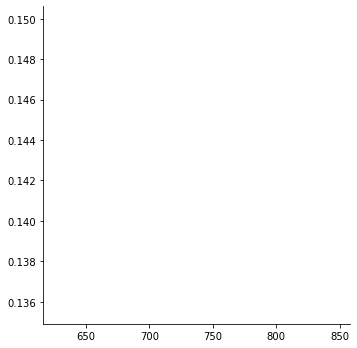

In [52]:
# Show the survival probability as a function of fico
g = sns.lmplot(x="fico", y="coFlag", data=devSet[['fico','coFlag']], y_jitter=.02, logistic=True, truncate=False,scatter=False)
g.set(xlim=(0, 900), ylim=(-.05, 1.05))